In [1]:
import sys; sys.path.append('..')

In [2]:
import math
import random

from itertools import product
from os import path

In [3]:
import networkx as nx
from matplotlib import pyplot as plt

In [4]:
from graph import Graph
from graph.disjointsets import DisjointSets
from graph.reader import read_problem
from graph.steiner import prunning_mst
from graph.util import has_cycle, how_many_components

In [5]:
from draw import draw_radial

---

In [6]:
# problema = path.join('..', 'datasets', 'ORLibrary', 'steinc1.txt')
problema = path.join('..', 'datasets', 'ORLibrary', 'steinb16.txt')

STPG = read_problem(problema)

In [7]:
STPG.nro_nodes

100

In [8]:
STPG.nro_edges

200

In [9]:
STPG.nro_terminals

17

In [10]:
print(STPG.terminals)

{97, 37, 69, 72, 9, 76, 60, 81, 82, 17, 20, 21, 54, 87, 25, 59, 28}


In [11]:
terminals = set(STPG.terminals)

def is_terminal(vertice):
    return vertice in terminals

In [12]:
def prunning(treegraph):
    
    to_eliminate = set()
    
    for v in treegraph.vertices:
        degree = treegraph.degree(v)
        if (not is_terminal(v)) and (degree == 1):
            to_eliminate.add(v)
        elif (degree == 0) and (not is_terminal(v)) :
            treegraph.remove_node(v)
    
    checkbefore = set()
    
    while to_eliminate:
        while to_eliminate:
            v = to_eliminate.pop()
            for adj in treegraph.adjacent_to(v):
                checkbefore.add(adj)
            treegraph.remove_node(v)

        while checkbefore:
            u = checkbefore.pop()
            if (not is_terminal(u)) and (treegraph.degree(u) == 1):
                to_eliminate.add(u)
                
    return treegraph   

In [13]:
def random_treegraph_chromosome(STPG):
    
    graph = STPG.graph
    terminals = set(STPG.terminals)
    
    alledges = [(v, u, graph.weight(v,u)) for v, u in graph.gen_undirect_edges()]
    random.shuffle(alledges) # random component

    DS = DisjointSets()
    subgraph = Graph()
    total_cost = 0
    
    for v in graph.vertices:
        DS.make_set(v)

    while alledges :
        v, u, weight = alledges.pop()

        if DS.find(v) != DS.find(u):
            DS.union(v, u)
            total_cost += weight
            subgraph.add_edge(v, u, weight=weight)
            terminals.discard(v)
            terminals.discard(u)

    return prunning(subgraph)

In [14]:
def partitioning(individuo_a, individuo_b):
    
    subtree_a = individuo_a.chromosome
    subtree_b = individuo_b.chromosome

    partition = Graph()
    offspring = Graph()
    
    for v, w in subtree_a.gen_undirect_edges():
        weight = subtree_a.weight(v,w)

        if subtree_b.has_edge(v, w):
            offspring.add_edge(v, w, weight=weight)
        else:
            partition.add_edge(v, w, weight=weight)
            
    for v, w in subtree_b.gen_undirect_edges():
        weight = subtree_b.weight(v,w)

        if not subtree_a.has_edge(v, w):
            partition.add_edge(v, w, weight=weight)
            
    return partition, offspring 

In [15]:
aa = random_treegraph_chromosome(STPG)

type(aa)

graph.graph.Graph

In [16]:
bb = random_treegraph_chromosome(STPG)

type(bb)

graph.graph.Graph

In [17]:
bb.edges

defaultdict(dict,
            {6: {56: 5, 4: 5},
             56: {6: 5, 21: 10},
             32: {97: 3, 4: 10},
             97: {32: 3, 92: 5},
             54: {50: 3},
             92: {76: 9, 24: 8, 3: 6, 97: 5},
             76: {92: 9},
             81: {30: 8},
             28: {40: 10},
             40: {28: 10, 19: 6},
             21: {60: 2, 56: 10},
             60: {21: 2},
             88: {74: 4, 57: 8},
             74: {88: 4, 9: 5},
             20: {29: 9},
             7: {18: 5, 44: 10, 12: 8},
             18: {7: 5, 15: 5, 51: 6, 30: 5},
             3: {72: 7, 92: 6},
             72: {3: 7, 91: 8, 25: 1},
             87: {69: 4, 9: 9, 82: 1},
             15: {18: 5, 66: 1},
             29: {51: 8, 20: 9},
             24: {92: 8, 89: 6},
             4: {32: 10, 6: 5},
             9: {61: 10, 36: 5, 74: 5, 87: 9},
             61: {9: 10, 51: 8},
             23: {33: 10, 44: 5},
             19: {89: 8, 40: 6},
             89: {19: 8, 24: 6},
         

In [18]:
d_terminals_aa = { v : aa.degree(v) for v in terminals }
d_terminals_bb = { v : bb.degree(v) for v in terminals }

d_terminals_aa
d_terminals_bb

{69: 1,
 72: 3,
 9: 4,
 76: 1,
 81: 1,
 82: 1,
 17: 1,
 20: 1,
 21: 2,
 87: 3,
 25: 1,
 28: 1,
 97: 2,
 37: 1,
 54: 1,
 59: 1,
 60: 1}

---

In [19]:
def union(aa, bb):
    gg_uniao = Graph()

    for v, u in aa.gen_undirect_edges():
        gg_uniao.add_edge(v, u, weight=aa[v][u])

    for v, u in bb.gen_undirect_edges():
        gg_uniao.add_edge(v, u, weight=bb[v][u])

    return gg_uniao

---

In [22]:
from collections import deque

def dfs_1(aa, bb, start):

    gg_uniao = union(aa, bb)
    gg_comum = Graph()
    gg_particoes = Graph()

    v_portal = set()
    particoes = list()

    vertices_visitados = set()
    pilha = deque()

    def visitar(v, u, peso=1, comum=True):   
        if comum :
            gg_comum.add_edge(v, u, weight=peso)
        else :
            if aa.has_node(v) and bb.has_node(v):
                v_portal.add(v)
            
            if aa.has_node(u) and bb.has_node(u):
                v_portal.add(u)

            gg_particoes.add_edge(v, u, weight=peso)

    def P(v):
        vertices_visitados.add(v)
        pilha.append(v)
            
        for w in gg_uniao.adjacent_to(v):
            is_common = aa.has_edge(v, w) and bb.has_edge(v, w)
            
            if not w in vertices_visitados:
                visitar(v, w, comum=is_common)
                P(w)
            elif (w in pilha) and w != pilha[-2]:
                visitar(v, w, comum=is_common)
                
        pilha.pop()

    P(start)

    return gg_uniao, gg_comum, gg_particoes


In [20]:
print(terminals)

{69, 72, 9, 76, 81, 82, 17, 20, 21, 87, 25, 28, 97, 37, 54, 59, 60}


In [21]:
start_node = 21

In [23]:
tamanho_populacao = 50

In [24]:
populacao = [ random_treegraph_chromosome(STPG) for _ in range(tamanho_populacao)]

In [25]:
from itertools import product

In [30]:
count = 0
data = list()

for aa, bb in product(populacao, repeat=2):
    if aa is not bb:
        count += 1
        gg_union, gg_comum, gg_part = dfs_1(aa, bb, 21)
        reg = [
            how_many_components(gg_comum),
            has_cycle(gg_comum),
            how_many_components(gg_part),
            has_cycle(gg_part)
        ]
        data.append(reg)

count

2450

In [32]:
import pandas as pd

In [62]:
col = [
    'comum_qtd_comp',
    'comum_ciclo',
    'part_qtd_comp',
    'part_ciclo'
]

frame = pd.DataFrame(data, columns=col)

In [63]:
frame

,comum_qtd_comp,comum_ciclo,part_qtd_comp,part_ciclo
0,7,False,1,True
1,10,False,1,True
2,10,False,1,True
3,6,False,2,True
4,6,False,1,True
...,...,...,...,...
2445,7,False,2,True
2446,10,False,2,True
2447,7,False,2,True
2448,7,False,1,True


In [64]:
frame.describe()

,comum_qtd_comp,part_qtd_comp
count,2450.000000,2450.000000
mean,8.235918,1.157551
std,1.803499,0.410750
min,3.000000,1.000000
25%,7.000000,1.000000
50%,8.000000,1.000000
75%,9.000000,1.000000
max,15.000000,4.000000


In [65]:
frame['part_ciclo'].all()

True

In [66]:
frame['comum_ciclo'].any()

False

In [67]:
(~ frame['comum_ciclo']).all()

True

In [68]:
frame['comum_ciclo'].unique()

array([False])

In [69]:
frame['part_ciclo'].unique()

array([ True])

In [79]:
frame['count'] = 0
group = frame.groupby(by='part_qtd_comp')['count'].count()

group

part_qtd_comp
1    2102
2     316
3      26
4       6
Name: count, dtype: int64

In [80]:
group.to_clipboard()

Text(0, 0.5, 'Frequência')

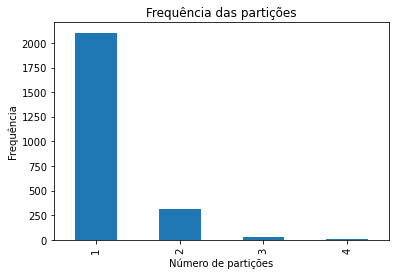

In [74]:
group.plot.bar()

plt.title('Frequência das partições')
plt.xlabel('Número de partições')
plt.ylabel('Frequência')

In [77]:
group = frame.groupby(by='comum_qtd_comp')['count'].count()

Text(0, 0.5, 'Frequência')

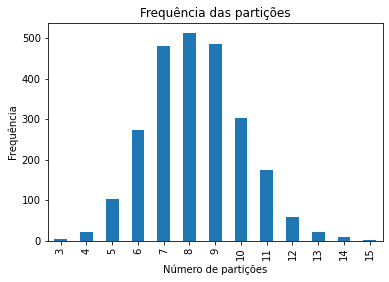

In [78]:
group.plot.bar()

plt.title('Frequência das partições')
plt.xlabel('Número de partições')
plt.ylabel('Frequência')

In [ ]:
from draw import draw_common, convert_graph

In [ ]:
draw_common(convert_graph(gg_uniao), 
        terminals, 
        convert_graph(aa), 
        convert_graph(bb))

In [ ]:
draw_common(convert_graph(gg_particoes), 
        terminals, 
        convert_graph(aa), 
        convert_graph(bb))

In [ ]:
gg = convert_graph(gg_particoes)